In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error 
import math

In [2]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


In [3]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


# 데이터 준비

In [4]:
# Time Series 생성
dataset_filepath  = os.getenv('HOME')  + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col = 'Date', parse_dates = True)
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

In [40]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4761.183105,74195000.0
2000-01-05,5800.0,6060.0,5520.0,5580.0,4348.184082,74680000.0
2000-01-06,5750.0,5780.0,5580.0,5620.0,4379.354004,54390000.0
2000-01-07,5560.0,5670.0,5360.0,5540.0,4317.015625,40305000.0
2000-01-10,5600.0,5770.0,5580.0,5770.0,4496.240723,46880000.0
...,...,...,...,...,...,...
2021-02-17,83900.0,84200.0,83000.0,83200.0,83200.000000,18307735.0
2021-02-18,83200.0,83600.0,82100.0,82100.0,82100.000000,21327683.0
2021-02-19,82300.0,82800.0,81000.0,82600.0,82600.000000,25880879.0


In [5]:
ts.tail()

Date
2021-02-17    83200.0
2021-02-18    82100.0
2021-02-19    82600.0
2021-02-22    82200.0
2021-02-23    82000.0
Name: Close, dtype: float64

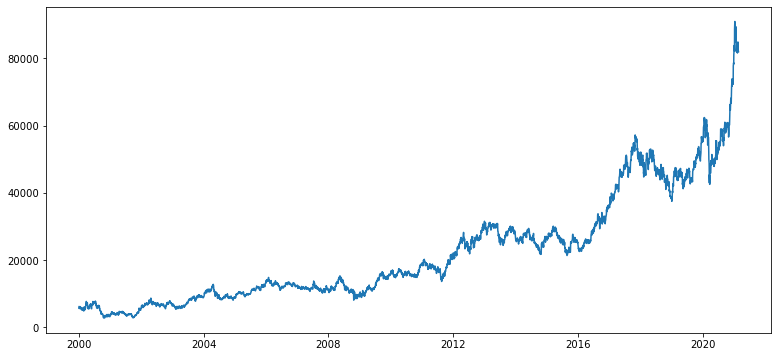

In [6]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

# 데이터 전처리

In [7]:
ts = ts.interpolate(method = 'time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [8]:
ts_log = np.log(ts)

# stationary 검정


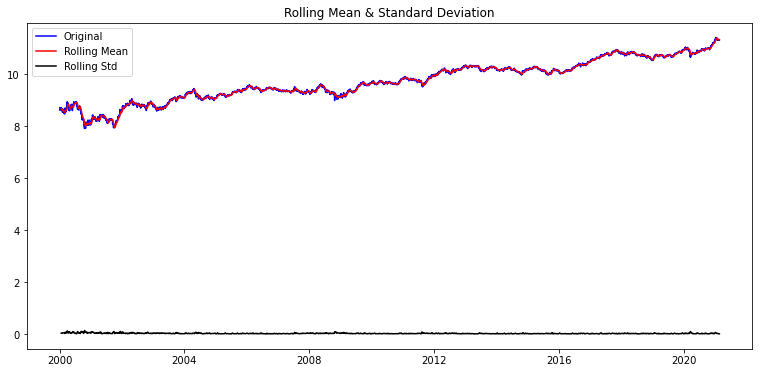

Results of Dickey-Fuller Test:
Test Statistic                   -0.327864
p-value                           0.921464
#Lags Used                        4.000000
Number of Observations Used    5310.000000
Critical Value (1%)              -3.431582
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


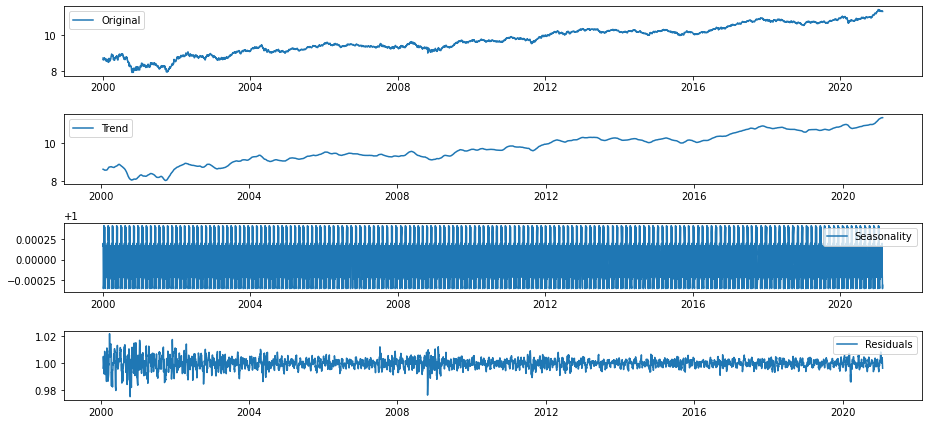

In [9]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
# [[YOUR CODE]]
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label = 'Original')
plt.legend(loc ='best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

In [10]:
residual.dropna(inplace =True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.761189e+01
p-value                        3.875990e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.251000e+03
Critical Value (1%)           -3.431596e+00
Critical Value (5%)           -2.862091e+00
Critical Value (10%)          -2.567063e+00
dtype: float64


residual은 상당히 stationary함을 볼 수 있다.

# train, test 데이터 분리

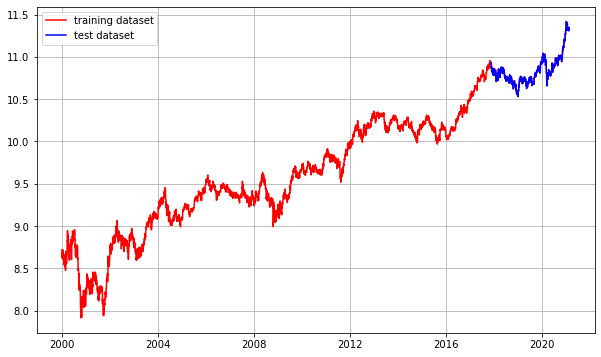

In [26]:
train_data, test_data = ts_log[ : int(len(ts_log)*0.85)], ts_log[int(len(ts_log)* 0.85 ): ]
plt.figure(figsize = (10,6))
plt.grid(True)
plt.plot(ts_log, c = 'r', label = 'training dataset')

plt.plot(test_data, c = 'b', label = 'test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기


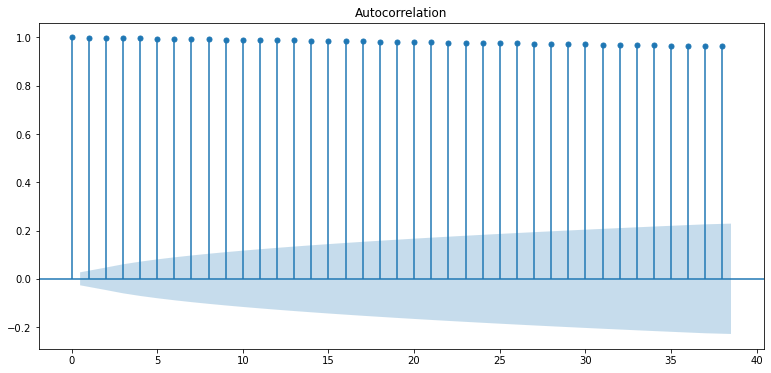

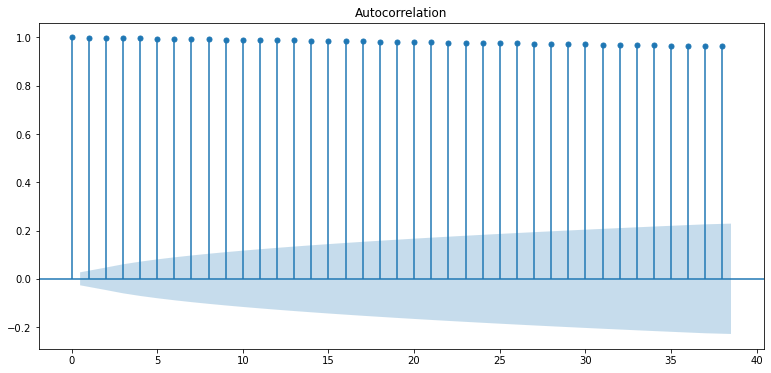

In [27]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# [[YOUR CODE]]

plot_acf(ts_log)
plot_acf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -40.092467
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5310.000000
Critical Value (1%)              -3.431582
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


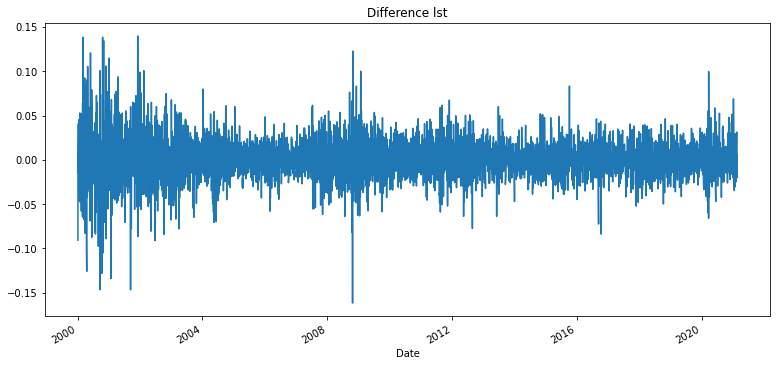

In [28]:
# 차분 안정성 확인 -> d 구하기
# [[YOUR CODE]]

# 1차 차분
diff_1 = ts_log.diff(periods = 1).iloc[1:]
diff_1.plot(title = 'Difference lst')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                  -21.807706
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5279.000000
Critical Value (1%)              -3.431589
Critical Value (5%)              -2.862088
Critical Value (10%)             -2.567062
dtype: float64


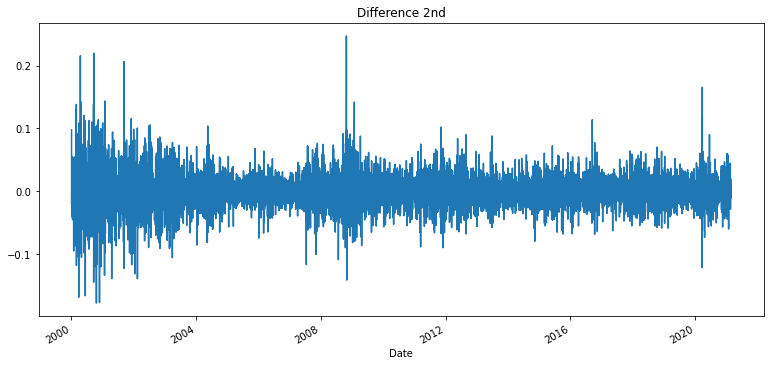

In [29]:
# 2차 차분 
diff_2 = diff_1.diff(periods = 1).iloc[1:]
diff_2.plot(title = 'Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# STEP 6 : ARIMA 모델 훈련과 테스트

ARIMA 모델 빌드와 훈련                
모델 테스트 및 플로팅     
최종 예측 모델 정확도 측정(MAPE)                



In [30]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order = (1,1,0))
fitted_m = model.fit(disp = -1)
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4516
Model:                 ARIMA(1, 1, 0)   Log Likelihood               10587.423
Method:                       css-mle   S.D. of innovations              0.023
Date:                Fri, 26 Feb 2021   AIC                         -21168.846
Time:                        15:14:14   BIC                         -21149.600
Sample:                             1   HQIC                        -21162.066
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0005      0.000      1.345      0.179      -0.000       0.001
ar.L1.D.Close     0.0460      0.015      3.087      0.002       0.017       0.075
                                    Root

/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provid

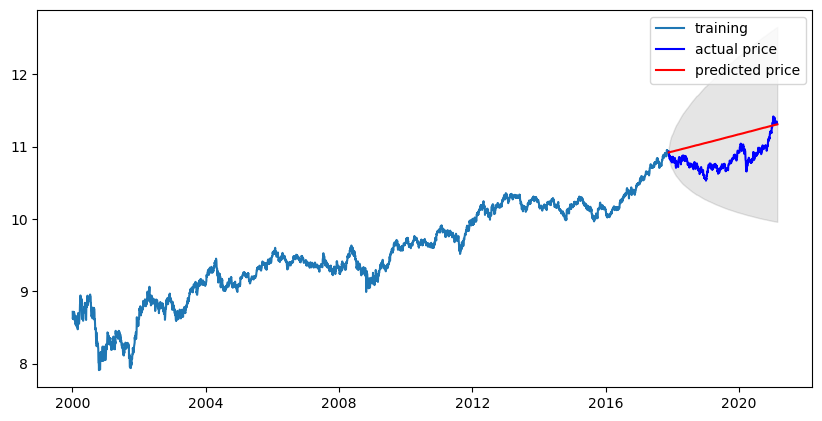

In [31]:
# Forecast : 결과가 fc에 담깁니다. 
# [[YOUR CODE]]

fc, se, conf = fitted_m.forecast(len(test_data), alpha = 0.05) 

# Make as pandas series
# [[YOUR CODE]]
fc_series = pd.Series(fc, index = test_data.index)
lower_series = pd.Series(conf[:, 0], index = test_data.index)
upper_series = pd.Series(conf[:, 1], index= test_data.index)

# Plot
# [[YOUR CODE]]

plt.figure(figsize = (10,5), dpi = 100)
plt.plot(train_data, label = 'training')
plt.plot(test_data, c = 'b' , label = 'actual price')
plt.plot(fc_series, c = 'r', label = 'predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color = 'k', alpha = .10)
plt.legend()
plt.show()


In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data)) / np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  303866367.09493184
MAE:  16153.397567629487
RMSE:  17431.763166556957
MAPE: 33.14%


# STEP 7 : 다른 주식 종목 예측해 보기

# 넷플릭스 

# 데이터 준비

In [4]:
# Time Series 생성
dataset_filepath  = os.getenv('HOME')  + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col = 'Date', parse_dates = True)
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

In [40]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4761.183105,74195000.0
2000-01-05,5800.0,6060.0,5520.0,5580.0,4348.184082,74680000.0
2000-01-06,5750.0,5780.0,5580.0,5620.0,4379.354004,54390000.0
2000-01-07,5560.0,5670.0,5360.0,5540.0,4317.015625,40305000.0
2000-01-10,5600.0,5770.0,5580.0,5770.0,4496.240723,46880000.0
...,...,...,...,...,...,...
2021-02-17,83900.0,84200.0,83000.0,83200.0,83200.000000,18307735.0
2021-02-18,83200.0,83600.0,82100.0,82100.0,82100.000000,21327683.0
2021-02-19,82300.0,82800.0,81000.0,82600.0,82600.000000,25880879.0


In [5]:
ts.tail()

Date
2021-02-17    83200.0
2021-02-18    82100.0
2021-02-19    82600.0
2021-02-22    82200.0
2021-02-23    82000.0
Name: Close, dtype: float64

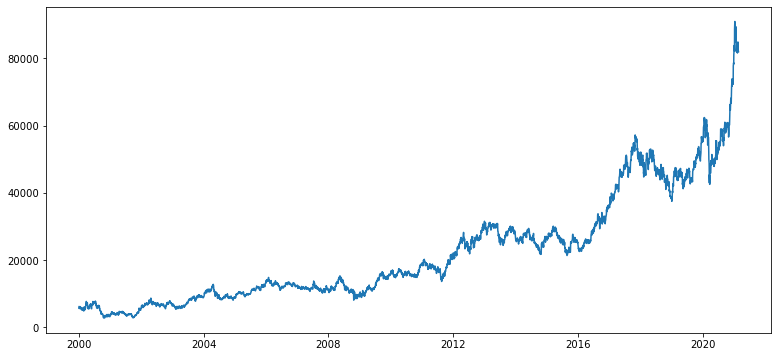

In [6]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

# 데이터 전처리

In [7]:
ts = ts.interpolate(method = 'time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [8]:
ts_log = np.log(ts)

# stationary 검정


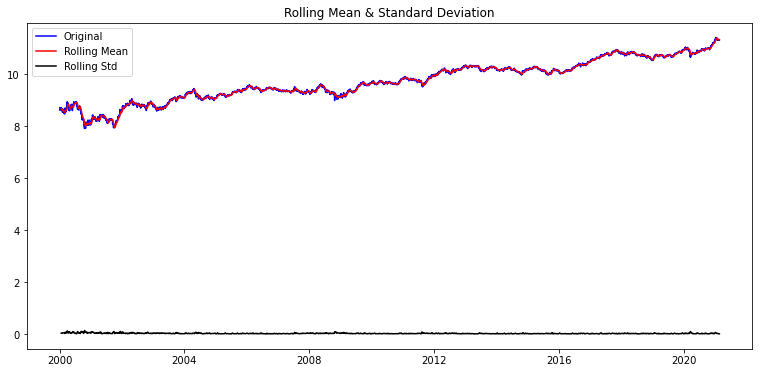

Results of Dickey-Fuller Test:
Test Statistic                   -0.327864
p-value                           0.921464
#Lags Used                        4.000000
Number of Observations Used    5310.000000
Critical Value (1%)              -3.431582
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


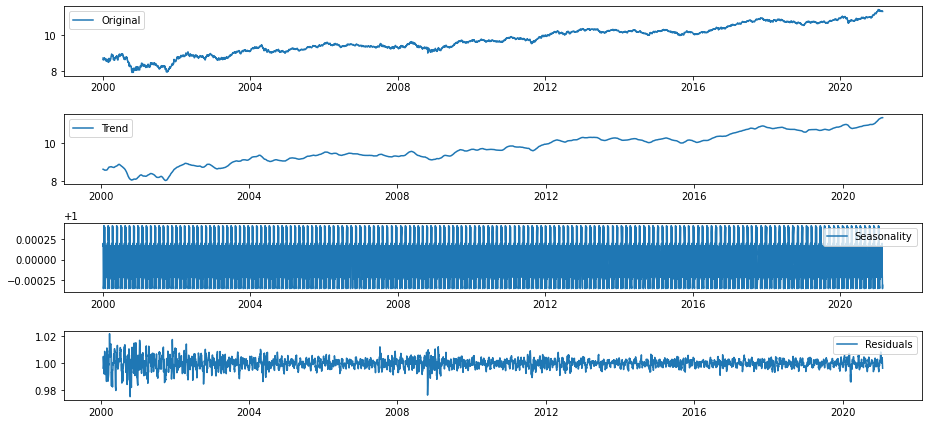

In [9]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
# [[YOUR CODE]]
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label = 'Original')
plt.legend(loc ='best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

In [10]:
residual.dropna(inplace =True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.761189e+01
p-value                        3.875990e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.251000e+03
Critical Value (1%)           -3.431596e+00
Critical Value (5%)           -2.862091e+00
Critical Value (10%)          -2.567063e+00
dtype: float64


residual은 상당히 stationary함을 볼 수 있다.

# train, test 데이터 분리

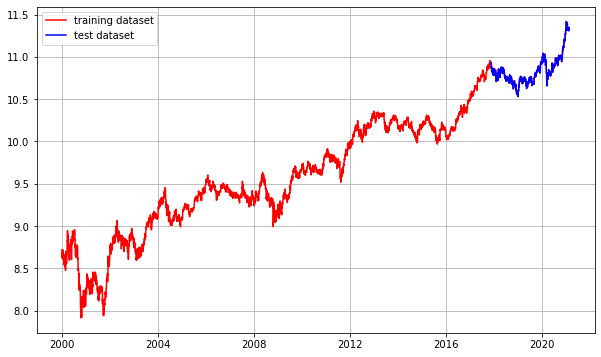

In [26]:
train_data, test_data = ts_log[ : int(len(ts_log)*0.85)], ts_log[int(len(ts_log)* 0.85 ): ]
plt.figure(figsize = (10,6))
plt.grid(True)
plt.plot(ts_log, c = 'r', label = 'training dataset')

plt.plot(test_data, c = 'b', label = 'test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기


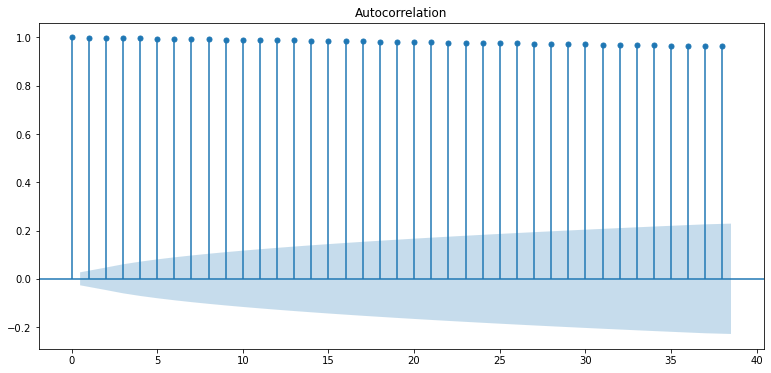

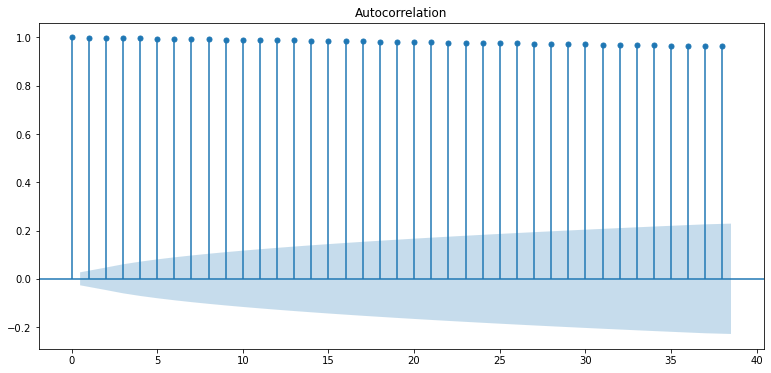

In [27]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# [[YOUR CODE]]

plot_acf(ts_log)
plot_acf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -40.092467
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5310.000000
Critical Value (1%)              -3.431582
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


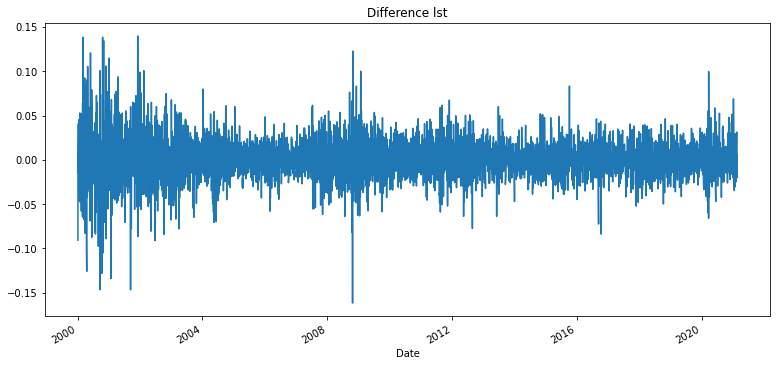

In [28]:
# 차분 안정성 확인 -> d 구하기
# [[YOUR CODE]]

# 1차 차분
diff_1 = ts_log.diff(periods = 1).iloc[1:]
diff_1.plot(title = 'Difference lst')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                  -21.807706
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5279.000000
Critical Value (1%)              -3.431589
Critical Value (5%)              -2.862088
Critical Value (10%)             -2.567062
dtype: float64


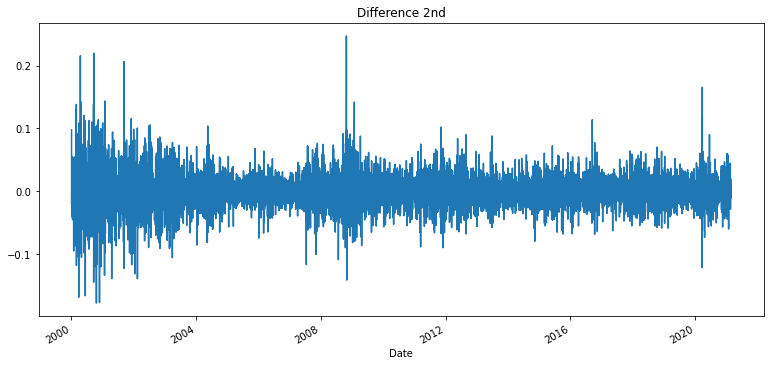

In [29]:
# 2차 차분 
diff_2 = diff_1.diff(periods = 1).iloc[1:]
diff_2.plot(title = 'Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# STEP 6 : ARIMA 모델 훈련과 테스트

ARIMA 모델 빌드와 훈련                
모델 테스트 및 플로팅     
최종 예측 모델 정확도 측정(MAPE)                



In [30]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order = (1,1,0))
fitted_m = model.fit(disp = -1)
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4516
Model:                 ARIMA(1, 1, 0)   Log Likelihood               10587.423
Method:                       css-mle   S.D. of innovations              0.023
Date:                Fri, 26 Feb 2021   AIC                         -21168.846
Time:                        15:14:14   BIC                         -21149.600
Sample:                             1   HQIC                        -21162.066
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0005      0.000      1.345      0.179      -0.000       0.001
ar.L1.D.Close     0.0460      0.015      3.087      0.002       0.017       0.075
                                    Root

/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provid

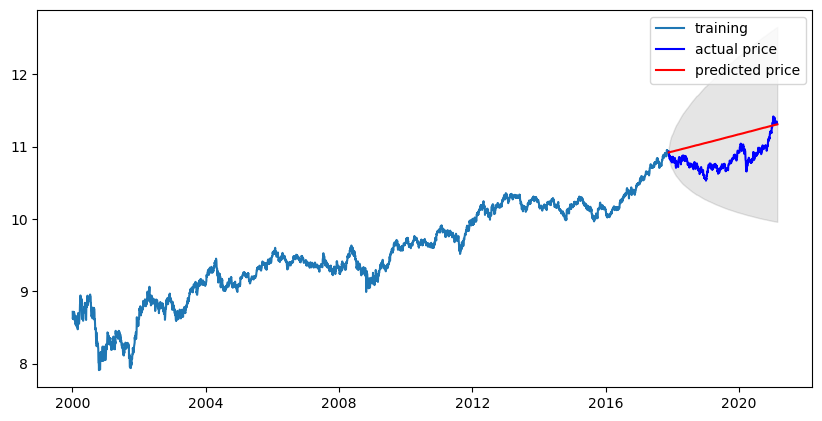

In [31]:
# Forecast : 결과가 fc에 담깁니다. 
# [[YOUR CODE]]

fc, se, conf = fitted_m.forecast(len(test_data), alpha = 0.05) 

# Make as pandas series
# [[YOUR CODE]]
fc_series = pd.Series(fc, index = test_data.index)
lower_series = pd.Series(conf[:, 0], index = test_data.index)
upper_series = pd.Series(conf[:, 1], index= test_data.index)

# Plot
# [[YOUR CODE]]

plt.figure(figsize = (10,5), dpi = 100)
plt.plot(train_data, label = 'training')
plt.plot(test_data, c = 'b' , label = 'actual price')
plt.plot(fc_series, c = 'r', label = 'predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color = 'k', alpha = .10)
plt.legend()
plt.show()


In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data)) / np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  303866367.09493184
MAE:  16153.397567629487
RMSE:  17431.763166556957
MAPE: 33.14%


# STEP 7 : 다른 주식 종목 예측해 보기

# 마이크로소프트

# 데이터 준비

In [4]:
# Time Series 생성
dataset_filepath  = os.getenv('HOME')  + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col = 'Date', parse_dates = True)
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

In [40]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4761.183105,74195000.0
2000-01-05,5800.0,6060.0,5520.0,5580.0,4348.184082,74680000.0
2000-01-06,5750.0,5780.0,5580.0,5620.0,4379.354004,54390000.0
2000-01-07,5560.0,5670.0,5360.0,5540.0,4317.015625,40305000.0
2000-01-10,5600.0,5770.0,5580.0,5770.0,4496.240723,46880000.0
...,...,...,...,...,...,...
2021-02-17,83900.0,84200.0,83000.0,83200.0,83200.000000,18307735.0
2021-02-18,83200.0,83600.0,82100.0,82100.0,82100.000000,21327683.0
2021-02-19,82300.0,82800.0,81000.0,82600.0,82600.000000,25880879.0


In [5]:
ts.tail()

Date
2021-02-17    83200.0
2021-02-18    82100.0
2021-02-19    82600.0
2021-02-22    82200.0
2021-02-23    82000.0
Name: Close, dtype: float64

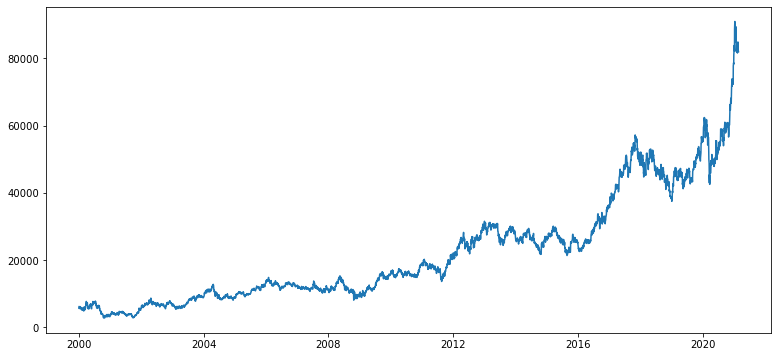

In [6]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

# 데이터 전처리

In [7]:
ts = ts.interpolate(method = 'time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [8]:
ts_log = np.log(ts)

# stationary 검정


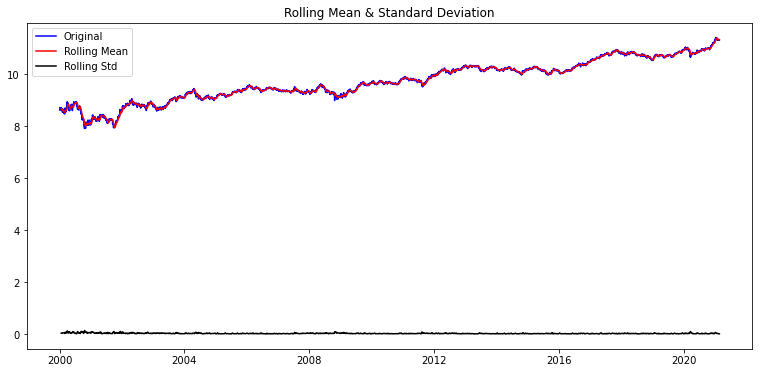

Results of Dickey-Fuller Test:
Test Statistic                   -0.327864
p-value                           0.921464
#Lags Used                        4.000000
Number of Observations Used    5310.000000
Critical Value (1%)              -3.431582
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


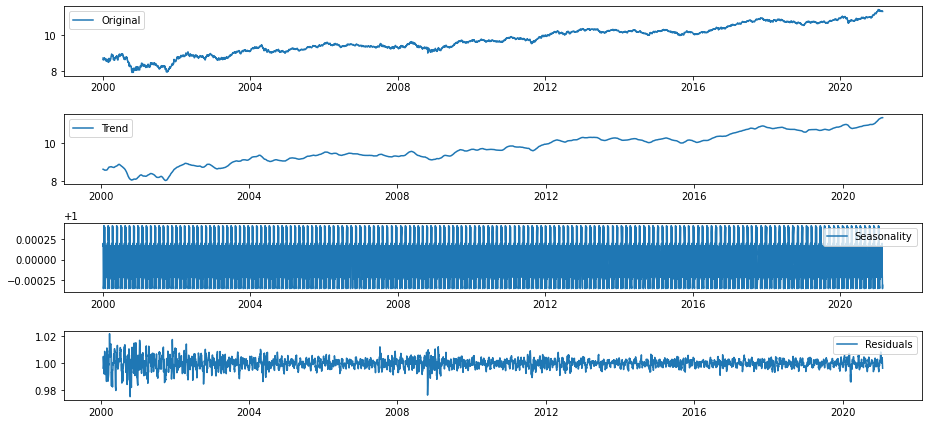

In [9]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
# [[YOUR CODE]]
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label = 'Original')
plt.legend(loc ='best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

In [10]:
residual.dropna(inplace =True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.761189e+01
p-value                        3.875990e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.251000e+03
Critical Value (1%)           -3.431596e+00
Critical Value (5%)           -2.862091e+00
Critical Value (10%)          -2.567063e+00
dtype: float64


residual은 상당히 stationary함을 볼 수 있다.

# train, test 데이터 분리

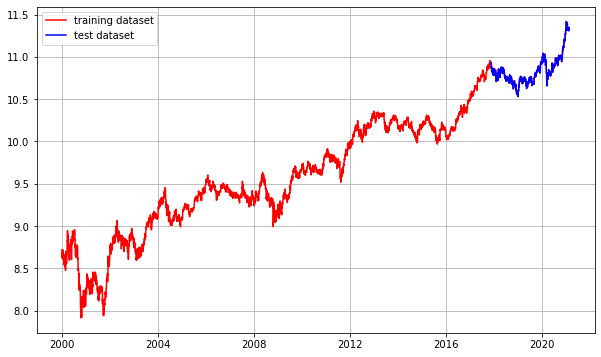

In [26]:
train_data, test_data = ts_log[ : int(len(ts_log)*0.85)], ts_log[int(len(ts_log)* 0.85 ): ]
plt.figure(figsize = (10,6))
plt.grid(True)
plt.plot(ts_log, c = 'r', label = 'training dataset')

plt.plot(test_data, c = 'b', label = 'test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기


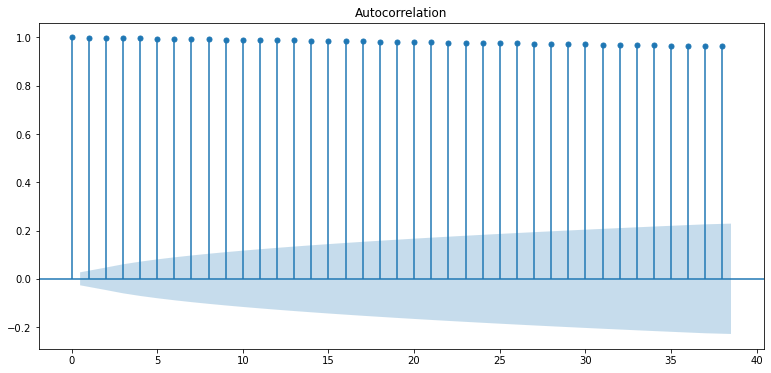

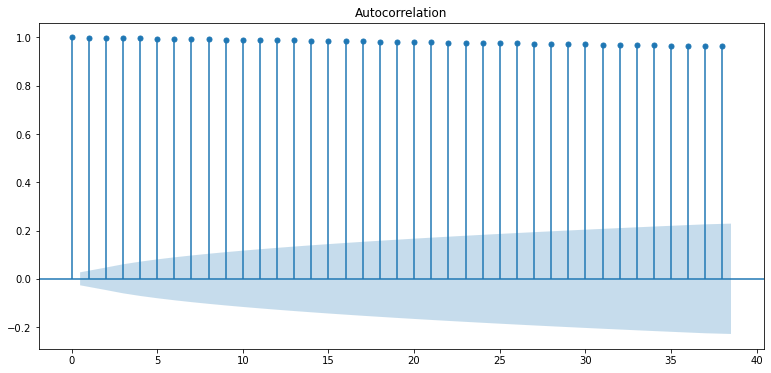

In [27]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# [[YOUR CODE]]

plot_acf(ts_log)
plot_acf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -40.092467
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5310.000000
Critical Value (1%)              -3.431582
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


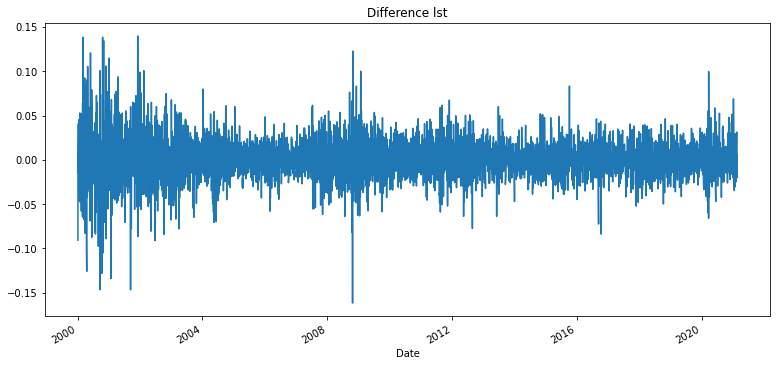

In [28]:
# 차분 안정성 확인 -> d 구하기
# [[YOUR CODE]]

# 1차 차분
diff_1 = ts_log.diff(periods = 1).iloc[1:]
diff_1.plot(title = 'Difference lst')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                  -21.807706
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5279.000000
Critical Value (1%)              -3.431589
Critical Value (5%)              -2.862088
Critical Value (10%)             -2.567062
dtype: float64


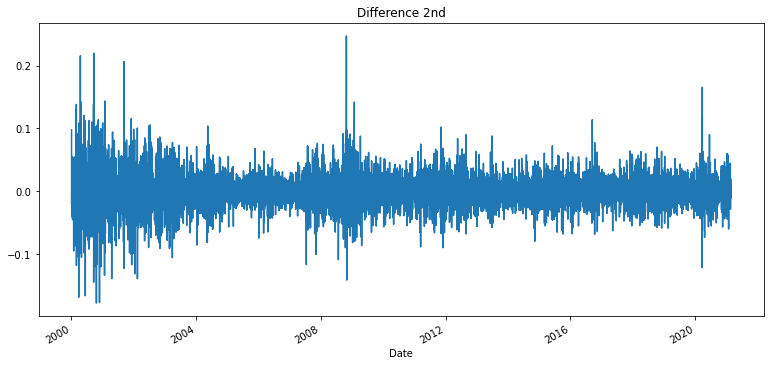

In [29]:
# 2차 차분 
diff_2 = diff_1.diff(periods = 1).iloc[1:]
diff_2.plot(title = 'Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# STEP 6 : ARIMA 모델 훈련과 테스트

ARIMA 모델 빌드와 훈련                
모델 테스트 및 플로팅     
최종 예측 모델 정확도 측정(MAPE)                



In [30]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order = (1,1,0))
fitted_m = model.fit(disp = -1)
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4516
Model:                 ARIMA(1, 1, 0)   Log Likelihood               10587.423
Method:                       css-mle   S.D. of innovations              0.023
Date:                Fri, 26 Feb 2021   AIC                         -21168.846
Time:                        15:14:14   BIC                         -21149.600
Sample:                             1   HQIC                        -21162.066
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0005      0.000      1.345      0.179      -0.000       0.001
ar.L1.D.Close     0.0460      0.015      3.087      0.002       0.017       0.075
                                    Root

/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provid

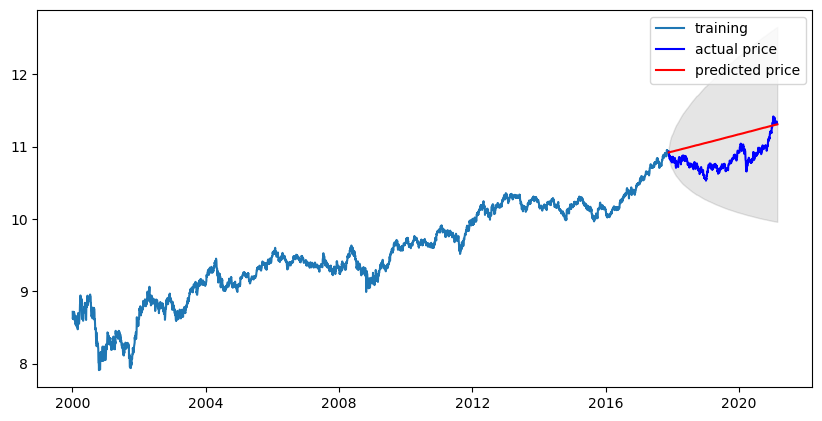

In [31]:
# Forecast : 결과가 fc에 담깁니다. 
# [[YOUR CODE]]

fc, se, conf = fitted_m.forecast(len(test_data), alpha = 0.05) 

# Make as pandas series
# [[YOUR CODE]]
fc_series = pd.Series(fc, index = test_data.index)
lower_series = pd.Series(conf[:, 0], index = test_data.index)
upper_series = pd.Series(conf[:, 1], index= test_data.index)

# Plot
# [[YOUR CODE]]

plt.figure(figsize = (10,5), dpi = 100)
plt.plot(train_data, label = 'training')
plt.plot(test_data, c = 'b' , label = 'actual price')
plt.plot(fc_series, c = 'r', label = 'predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color = 'k', alpha = .10)
plt.legend()
plt.show()


In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data)) / np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  303866367.09493184
MAE:  16153.397567629487
RMSE:  17431.763166556957
MAPE: 33.14%


In [ ]:
# STEP 7 : 다른 주식 종목 예측해 보기

# 넷플릭스 

# 데이터 준비

# Time Series 생성
dataset_filepath  = os.getenv('HOME')  + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col = 'Date', parse_dates = True)
ts = df['Close']
print(type(ts))
ts.head()

df

ts.tail()

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

# 데이터 전처리

ts = ts.interpolate(method = 'time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

ts_log = np.log(ts)

# stationary 검정


# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
# [[YOUR CODE]]
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label = 'Original')
plt.legend(loc ='best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

residual.dropna(inplace =True)
augmented_dickey_fuller_test(residual)

residual은 상당히 stationary함을 볼 수 있다.

# train, test 데이터 분리

train_data, test_data = ts_log[ : int(len(ts_log)*0.85)], ts_log[int(len(ts_log)* 0.85 ): ]
plt.figure(figsize = (10,6))
plt.grid(True)
plt.plot(ts_log, c = 'r', label = 'training dataset')

plt.plot(test_data, c = 'b', label = 'test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기


# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# [[YOUR CODE]]

plot_acf(ts_log)
plot_acf(ts_log)
plt.show()

# 차분 안정성 확인 -> d 구하기
# [[YOUR CODE]]

# 1차 차분
diff_1 = ts_log.diff(periods = 1).iloc[1:]
diff_1.plot(title = 'Difference lst')

augmented_dickey_fuller_test(diff_1)

# 2차 차분 
diff_2 = diff_1.diff(periods = 1).iloc[1:]
diff_2.plot(title = 'Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# STEP 6 : ARIMA 모델 훈련과 테스트

ARIMA 모델 빌드와 훈련                
모델 테스트 및 플로팅     
최종 예측 모델 정확도 측정(MAPE)                



from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order = (1,1,0))
fitted_m = model.fit(disp = -1)
print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
# [[YOUR CODE]]

fc, se, conf = fitted_m.forecast(len(test_data), alpha = 0.05) 

# Make as pandas series
# [[YOUR CODE]]
fc_series = pd.Series(fc, index = test_data.index)
lower_series = pd.Series(conf[:, 0], index = test_data.index)
upper_series = pd.Series(conf[:, 1], index= test_data.index)

# Plot
# [[YOUR CODE]]

plt.figure(figsize = (10,5), dpi = 100)
plt.plot(train_data, label = 'training')
plt.plot(test_data, c = 'b' , label = 'actual price')
plt.plot(fc_series, c = 'r', label = 'predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color = 'k', alpha = .10)
plt.legend()
plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data)) / np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

In [ ]:
d